In the Week 4 Exercise, you will build a linear regression model to predict fuel efficiency (miles per gallon) of automobiles. Download the auto-mpg.csv dataset from: Auto-mpg dataset. 
Load the data as a Pandas data frame and ensure that it imported correctly.

In [30]:
import pandas as pd
mpg = pd.read_csv("auto-mpg.csv")
rows,columns=mpg.shape
print("There are {} rows and {} columns.".format(rows,columns))
mpg[mpg['origin']==3].head()

There are 398 rows and 9 columns.


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
14,24.0,4,113.0,95,2372,15.0,70,3,toyota corona mark ii
18,27.0,4,97.0,88,2130,14.5,70,3,datsun pl510
29,27.0,4,97.0,88,2130,14.5,71,3,datsun pl510
31,25.0,4,113.0,95,2228,14.0,71,3,toyota corona
53,31.0,4,71.0,65,1773,19.0,71,3,toyota corolla 1200


Begin by prepping the data for modeling:
* Remove the car name column.
* The horsepower column values likely imported as a string data type. Figure out why and replace any strings with the column mean.
* Create dummy variables for the origin column. (It appears that 1 Is American, 2 is European, 3 is Japanese)

In [31]:
mpg = mpg.drop(columns=['car name'])

# Replace string horsepower values with the mean value for the column
horsepower_mean = pd.to_numeric(mpg['horsepower'], errors='coerce').dropna().mean()
mask = pd.to_numeric(mpg['horsepower'], errors='coerce').isna()
print("These are the non-numeric values in the 'horsepower' column, which caused it to be read as a string:\n",mpg['horsepower'][mask],"\nWe are replacing them with the mean of: ",horsepower_mean)
modified = mpg['horsepower'].copy()
modified[mask]=horsepower_mean
mpg['horsepower']=modified
mpg['horsepower'] = pd.to_numeric(mpg['horsepower'])

# Add dummy variables (binaries) for origin values
mpg['american']=mpg['origin']==1
mpg['european']=mpg['origin']==2
mpg['japanese']=mpg['origin']==3

These are the non-numeric values in the 'horsepower' column, which caused it to be read as a string:
 32     ?
126    ?
330    ?
336    ?
354    ?
374    ?
Name: horsepower, dtype: object 
We are replacing them with the mean of:  104.46938775510205


**Create a correlation coefficient matrix and/or visualization. Are there features highly correlated with mpg?**

In [32]:
mpg.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,american,european,japanese
mpg,1.000000,-0.775396,-0.804203,-0.771437,-0.831741,0.420289,0.579267,0.563450,-0.568192,0.259022,0.442174
cylinders,-0.775396,1.000000,0.950721,0.838939,0.896017,-0.505419,-0.348746,-0.562543,0.604351,-0.352861,-0.396479
displacement,-0.804203,0.950721,1.000000,0.893646,0.932824,-0.543684,-0.370164,-0.609409,0.651407,-0.373886,-0.433505
horsepower,-0.771437,0.838939,0.893646,1.000000,0.860574,-0.684259,-0.411651,-0.453669,0.486083,-0.281258,-0.321325
weight,-0.831741,0.896017,0.932824,0.860574,1.000000,-0.417457,-0.306564,-0.581024,0.598398,-0.298843,-0.440817
acceleration,0.420289,-0.505419,-0.543684,-0.684259,-0.417457,1.000000,0.288137,0.205873,-0.250806,0.204473,0.109144
model year,0.579267,-0.348746,-0.370164,-0.411651,-0.306564,0.288137,1.000000,0.180662,-0.139883,-0.024489,0.193101
origin,0.563450,-0.562543,-0.609409,-0.453669,-0.581024,0.205873,0.180662,1.000000,-0.924486,0.246332,0.886596
american,-0.568192,0.604351,0.651407,0.486083,0.598398,-0.250806,-0.139883,-0.924486,1.000000,-0.597198,-0.643317
european,0.259022,-0.352861,-0.373886,-0.281258,-0.298843,0.204473,-0.024489,0.246332,-0.597198,1.000000,-0.229895


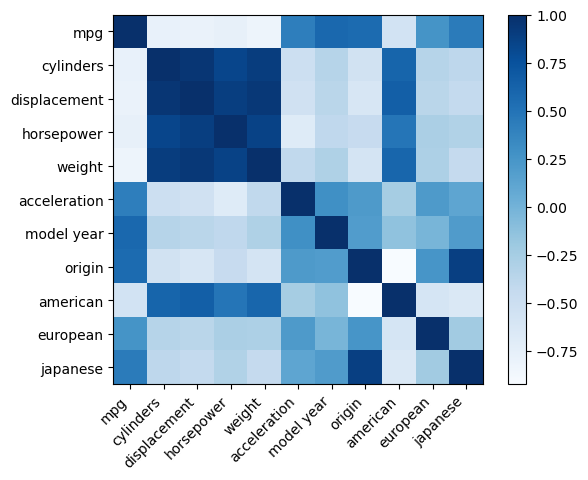

In [34]:
# Adapted from https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
matrix = mpg.corr()

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

Looking for correlations values greater than 0.5, the following values are all closely correlated with each other:
* cylinders
* displacement
* horsepower
* weight

These same values are inversely correlated with mpg.

Also, american is correlated with cylinders and displacement, and inversely correlated with mpg.

Additionally, mpg and model year are correlated.

**Plot mpg versus weight. Analyze this graph and explain how it relates to the corresponding correlation coefficient.**

<Axes: xlabel='weight', ylabel='mpg'>

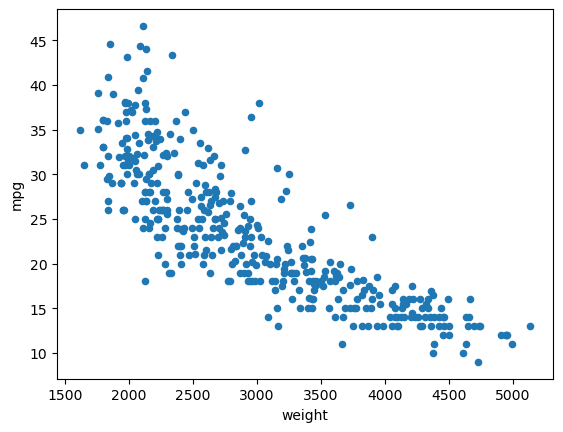

In [36]:
mpg.plot.scatter(x='weight', y='mpg')

Weight and mpg are inversely correlated fairly strongly with a coefficient of -0.831741. You can see this on the graph in the fact that a trend line would slope downwards towards the right. You can also see that the pattern is a downward slope and might be modeled better logarithmically, but is still modeled very well linearly. Mpg clearly decreases, on average, as weight increases.

**Randomly split the data into 80% training data and 20% test data, where your target is mpg.**

In [38]:
from sklearn.model_selection import train_test_split

data = mpg.drop('mpg', axis=1)
target = mpg['mpg']

# Split the data into 80% training and 20% testing
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

print(data_train.shape, data_test.shape)
print(target_train.shape, target_test.shape)

(318, 10) (80, 10)
(318,) (80,)


**Train an ordinary linear regression on the training data.**

In [42]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(data_train,target_train)
print(linear_model.intercept_)
print(linear_model.coef_)

# Obtain the predictions
target_pred = linear_model.predict(data_test)

-21.971261257955092
[-0.16373048  0.01958399 -0.01334457 -0.00707275  0.07335016  0.82739747
  0.88430052 -0.97974802  1.07519552 -0.0954475 ]


**Calculate R2, RMSE, and MAE on both the training and test sets and interpret your results.**

In [55]:
import sklearn.metrics as metrics
import numpy as np

def print_model_metrics(test,pred):
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(test, pred)
    
    print("R-Squared:", r2)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolue Error (MAE): ",mae)

print("Linear Regression Model Metrics:")
print_model_metrics(target_test,target_pred)

Linear Regression Model Metrics:
R-Squared: 0.8449006123776615
Root Mean Squared Error (RMSE): 2.8877573478836327
Mean Absolue Error (MAE):  2.2875867704421085


**Pick another regression model and repeat the previous two steps. Note: Do NOT choose logistic regression as it is more like a classification model.**

In [56]:
from sklearn.preprocessing import PolynomialFeatures

# Train polynomial regression model on the whole dataset
poly = PolynomialFeatures(degree = 2, include_bias=False)
train_poly = poly.fit_transform(data_train)
test_poly = poly.fit_transform(data_test)

poly_model = LinearRegression()
poly_model.fit(train_poly, target_train)
poly_pred=poly_model.predict(test_poly)

print("Polynomical Regression Model Metrics:")
print_model_metrics(target_test,poly_pred)

Polynomical Regression Model Metrics:
R-Squared: 0.8945181878762949
Root Mean Squared Error (RMSE): 2.3814663378257643
Mean Absolue Error (MAE):  1.7498402349944164
